# Heart Attack Analysis & Prediction

Import Libraries

In [18]:
import pandas as pd
from termcolor import colored
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder

1. Import Data

In [3]:
df = pd.read_csv("../heart_failure.csv", sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [4]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


2. Data Reviewing

Define the constraints for the columns

In [5]:
constraints = {
    'Age': lambda x: x > 0,
    'Sex': lambda x: x in ['M', 'F'],
    'ChestPainType': lambda x: x in ['TA', 'ATA', 'NAP', 'ASY'],
    'RestingBP': lambda x: x > 0,
    'Cholesterol': lambda x: x > 0,
    'FastingBS': lambda x: x in [0, 1],
    'RestingECG': lambda x: x in ['Normal', 'ST', 'LVH'],
    'MaxHR': lambda x: 60 <= x <= 202,
    'ExerciseAngina': lambda x: x in ['Y', 'N'],
    'Oldpeak': lambda x: x >= 0,
    'ST_Slope': lambda x: x in ['Up', 'Flat', 'Down'],
    'HeartDisease': lambda x: x in [0, 1]
}

Checking whether the records match the definitions

In [6]:
def check_constraints(df, constraints):
    violations = {}
    for column, constraint in constraints.items():
        invalid_rows = df[~df[column].apply(constraint)]
        if not invalid_rows.empty:
            violations[column] = invalid_rows.index.tolist()
    return violations

violations = check_constraints(df, constraints)
if violations:
    print("Constraint Violations Found:")
    for column, rows in violations.items():
        print(f"{column}: {rows}")
else:
    print("All records match the constraints.")


Constraint Violations Found:
RestingBP: [449]
Cholesterol: [293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 421, 423, 424, 427, 428, 429, 430, 434, 435, 436, 437, 438, 439, 440, 441, 442, 446, 449, 450, 451, 453, 455, 456, 457, 458, 459, 461, 463, 464, 466, 467, 470, 471, 472, 474, 475, 477, 479, 480, 481, 483, 484, 492, 508, 514, 515, 518, 535, 536]
Oldpeak: [321, 324, 325, 326, 331, 332, 334, 335, 352, 407, 413, 421, 512]


Count all values in the columns with data emissions 

In [7]:
def count_invalid_values(df, column, constraint):
    invalid_values = df[~df[column].apply(constraint)]
    return invalid_values[column].value_counts()

invalid_restingbp_counts = count_invalid_values(df, 'RestingBP', constraints['RestingBP'])
invalid_cholesterol_counts = count_invalid_values(df, 'Cholesterol', constraints['Cholesterol'])
invalid_oldpeak_counts = count_invalid_values(df, 'Oldpeak', constraints['Oldpeak'])

print("Invalid Counts:\n")
print(invalid_restingbp_counts)
print(invalid_cholesterol_counts)
print(invalid_oldpeak_counts)

Invalid Counts:

RestingBP
0    1
Name: count, dtype: int64
Cholesterol
0    172
Name: count, dtype: int64
Oldpeak
-0.1    2
-1.0    2
-0.5    2
-0.9    1
-2.6    1
-1.5    1
-1.1    1
-0.7    1
-0.8    1
-2.0    1
Name: count, dtype: int64


Correct `RestingBP`

In [8]:
df['RestingBP'] = df['RestingBP'].replace(0, df['RestingBP'].mean())

print("Corrected RestingBP for the row #449:", df.loc[449, 'RestingBP'])

Corrected RestingBP for the row #449: 132.39651416122004


Deal with `Cholesterol` zero values

Calculating correlation between the `Cholesterol` and `HeartDisease`  before data manipulations

In [21]:
before_manipulating = df['Cholesterol'].corr(df['HeartDisease'])
mean_manipulating = df['Cholesterol'].replace(0, np.nan).fillna(df['Cholesterol'].mean()).corr(df['HeartDisease'])
median_manipulating = df['Cholesterol'].replace(0, np.nan).fillna(df['Cholesterol'].median()).corr(df['HeartDisease'])
drop_manipulating = df['Cholesterol'].replace(0, np.nan).dropna().corr(df['HeartDisease'])

print("Correlation between HeartDisease and Cholesterol:")
print(f"Before manipulations: {colored(before_manipulating, 'red' if before_manipulating < 0 else 'yellow' if before_manipulating <= 0.5 else 'green')}")
print(f"After applying mean: {colored(mean_manipulating, 'red' if mean_manipulating < 0 else 'yellow' if mean_manipulating <= 0.5 else 'green')}")
print(f"After applying median: {colored(median_manipulating, 'red' if median_manipulating < 0 else 'yellow' if median_manipulating <= 0.5 else 'green')}")
print(f"After dropping values: {colored(drop_manipulating, 'red' if drop_manipulating < 0 else 'yellow' if drop_manipulating <= 0.1 else 'green')}")

Correlation between HeartDisease and Cholesterol:
Before manipulations: -0.2327406389270117
After applying mean: -0.012339719075300236
After applying median: 0.04298784362551656
After dropping values: 0.10386559562465622


Check whether dropping values affects other correlation with `HeartDease`

In [101]:
df_encoded_original = pd.get_dummies(df, columns=['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'])
df_encoded = df_encoded_original[df_encoded_original['Cholesterol'] > 0]

corr_before = df_encoded_original.corr()['HeartDisease']
corr_after = df_encoded.corr()['HeartDisease']


In [102]:
def highlight_changes(s):
    is_high = (s['After'] - s['Before']) > 0.1
    is_low = (s['Before'] - s['After']) > 0.1
    is_higher = (s['After'] - s['Before']) > 0.01
    is_lower = (s['Before'] - s['After']) > 0.01
    return ['background-color: green' if is_high else 'background-color: red' if is_low else 'background-color: lime' if is_higher else 'background-color: pink' if is_lower else '' for v in s]

comparison = pd.DataFrame({'Before': corr_before, 'After': corr_after, 'Difference': corr_after - corr_before})
comparison.style.apply(highlight_changes, axis=1)


,Before,After,Difference
Age,0.282039,0.298617,0.016578
RestingBP,0.117930,0.173242,0.055311
Cholesterol,-0.232741,0.103866,0.336606
FastingBS,0.267291,0.160594,-0.106697
MaxHR,-0.400421,-0.377212,0.023209
Oldpeak,0.403951,0.495696,0.091746
HeartDisease,1.000000,1.000000,0.000000
Sex_F,-0.305445,-0.292779,0.012666
Sex_M,0.305445,0.292779,-0.012666
ChestPainType_ASY,0.516716,0.522982,0.006266


Check all the correlation changes before and after delete zero values

In [129]:
corr_change = df_encoded.corr() - df_encoded_original.corr()

def highlight_significant(val):
    color = 'red' if abs(val) > 0.1 else 'black'
    return f'color: {color}'

styled_corr_change = corr_change.style.map(highlight_significant)
styled_corr_change

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
Age,0.000000,-0.003215,0.154040,0.043299,-0.000067,0.027395,0.016578,0.014833,-0.014833,0.020130,-0.011654,-0.010936,0.018629,0.033334,-0.008026,-0.026946,-0.030116,0.030116,0.010590,0.016980,-0.014228
RestingBP,-0.003215,0.000000,0.006692,0.105949,-0.016105,0.024360,0.055311,-0.024942,0.024942,0.037551,-0.024729,-0.026800,0.015604,-0.027431,0.027640,-0.002459,-0.008020,0.008020,0.107235,-0.028357,-0.021159
Cholesterol,0.154040,0.006692,0.000000,0.314987,-0.255648,0.008340,0.336606,-0.093047,0.093047,0.214002,-0.166900,-0.061806,-0.067618,-0.097488,-0.008480,0.104301,-0.120934,0.120934,0.072637,0.154948,-0.193089
FastingBS,0.043299,0.105949,0.314987,0.000000,0.028729,0.002870,-0.106697,0.024001,-0.024001,-0.080906,0.047189,0.045100,0.022409,0.083591,-0.072053,0.007963,-0.049545,0.049545,-0.015860,-0.001464,0.014421
MaxHR,-0.000067,-0.016105,-0.255648,0.028729,0.000000,-0.098842,0.023209,-0.032184,0.032184,-0.016528,-0.010406,0.017740,-0.008894,-0.030317,0.015353,-0.002094,0.025864,-0.025864,-0.004539,-0.003572,-0.000610
Oldpeak,0.027395,0.024360,0.008340,0.002870,-0.098842,0.000000,0.091746,-0.020009,0.020009,0.066327,-0.041075,-0.029606,0.010747,0.009255,-0.014059,0.006640,-0.056738,0.056738,0.068041,0.087347,-0.102599
HeartDisease,0.016578,0.055311,0.336606,-0.106697,0.023209,0.091746,0.000000,0.012666,-0.012666,0.006266,0.026290,-0.009182,0.001025,0.058929,-0.041675,-0.006606,-0.057553,0.057553,0.009666,0.037420,-0.031595
Sex_F,0.014833,-0.024942,-0.093047,0.024001,-0.032184,-0.020009,0.012666,0.000000,0.000000,0.007408,-0.022687,0.013816,-0.017763,-0.019659,-0.007871,0.026141,0.001915,-0.001915,-0.007495,0.013790,-0.014229
Sex_M,-0.014833,0.024942,0.093047,-0.024001,0.032184,0.020009,-0.012666,0.000000,0.000000,-0.007408,0.022687,-0.013816,0.017763,0.019659,0.007871,-0.026141,-0.001915,0.001915,0.007495,-0.013790,0.014229
ChestPainType_ASY,0.020130,0.037551,0.214002,-0.080906,-0.016528,0.066327,0.006266,0.007408,-0.007408,0.000000,-0.008266,0.040808,0.009780,0.052697,-0.044109,0.002547,-0.052990,0.052990,0.007866,0.042250,-0.038695


3. Data Analysis

Count all patient's heart disease chance

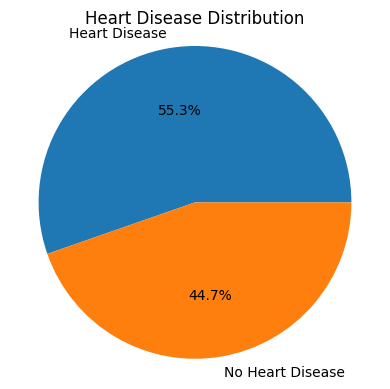

In [110]:
heart_disease_counts = df['HeartDisease'].value_counts()

plt.figure(figsize=(4, 4))
plt.title('Heart Disease Distribution')
plt.pie(heart_disease_counts, labels=['Heart Disease', 'No Heart Disease'], autopct='%1.1f%%')
plt.axis('equal')
plt.tight_layout()

Display the correlation heatmap

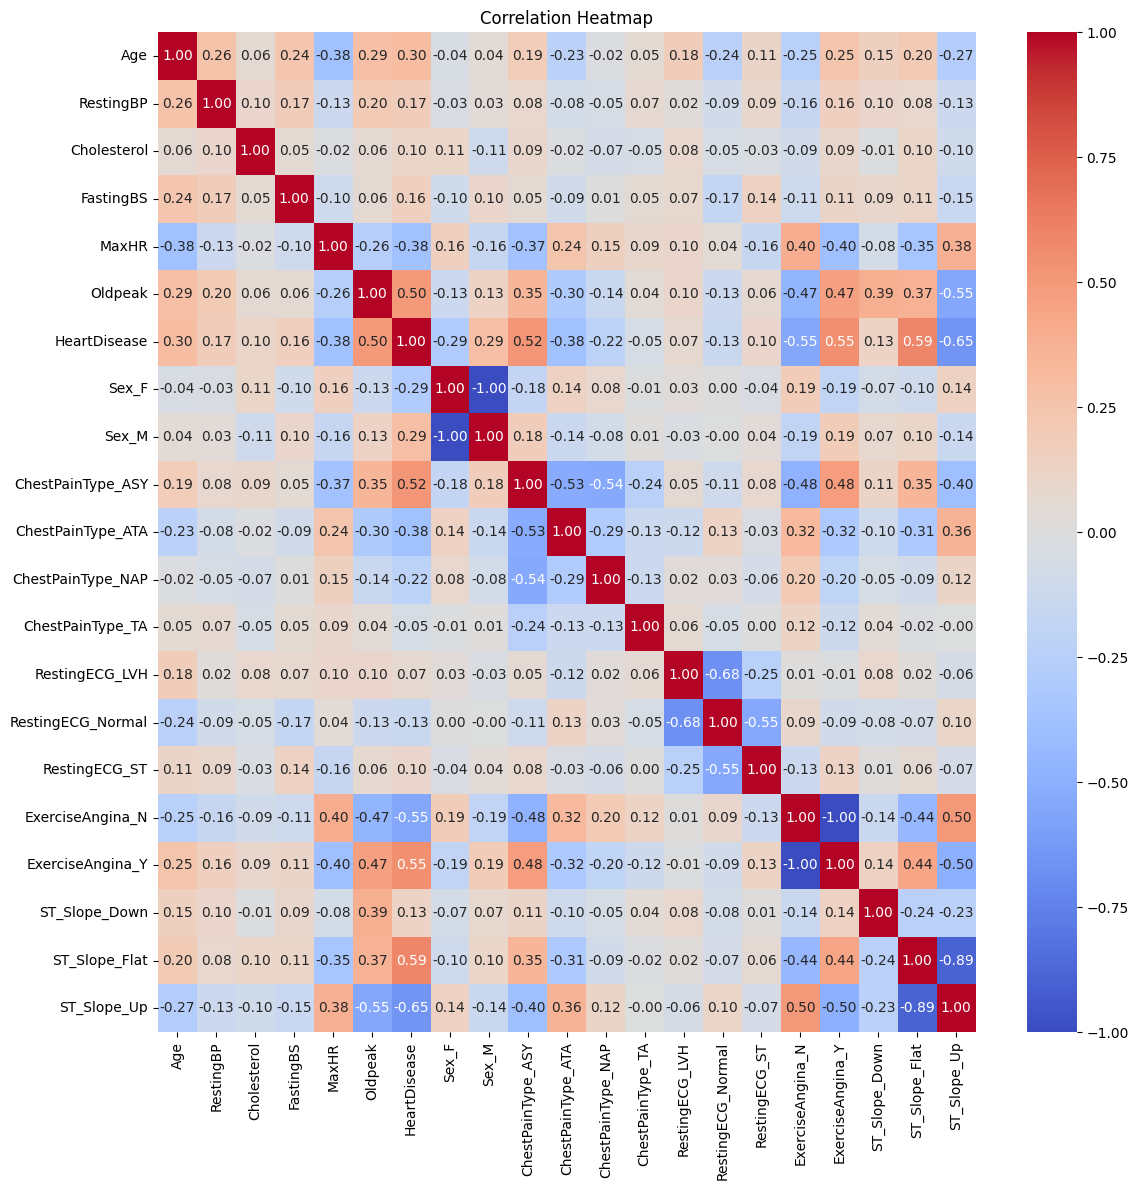

In [152]:
plt.figure(figsize=(12, 12))
sns.heatmap(df_encoded.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()


<Axes: xlabel='Age', ylabel='Density'>

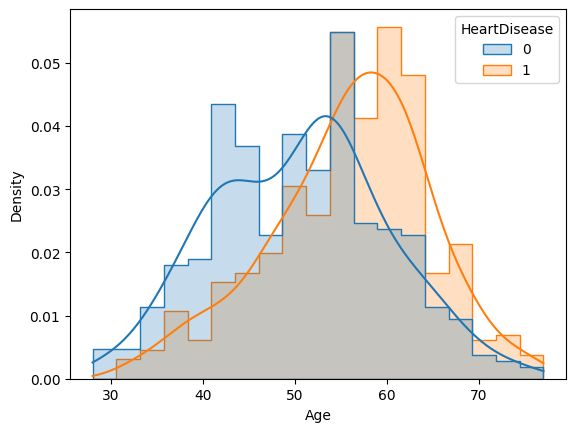

In [148]:
sns.histplot(data=df, x='Age', hue='HeartDisease', element='step', stat='density', common_norm=False, kde=True)

<Axes: xlabel='cp', ylabel='Density'>

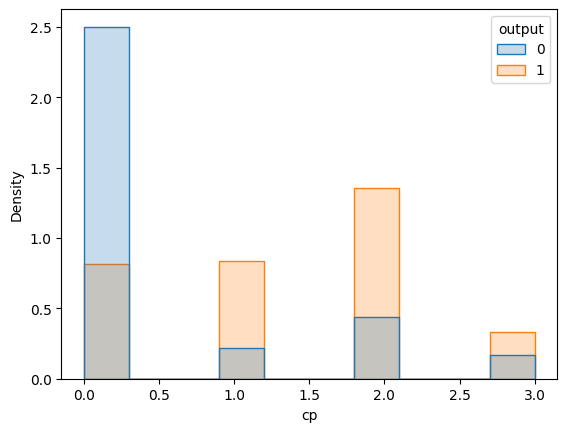

In [17]:
sns.histplot(data=df, x='cp', hue='output', element='step', stat='density', common_norm=False)